In [1]:
test_mp4, test_depth = "./raw_data/rgb_20250709_000819", "./raw_data/depth_20250709_000819"

In [2]:
import cv2
from frame_processor import FrameProcessor
from mock_camera import MockCamera

from config import Config 
Config.POINT_CLOUD_STRIDE=1

# Инициализация
Config.CAMERA_INTRINSICS={
                'fx': 390.4425964355469, 
                'fy': 390.4425964355469,
                'cx': 320.0,
                'cy': 240.0,
                'depth_scale': 0.001
            }
Config.MAX_OBSERVATIONS=30
camera_intrinsics = Config.CAMERA_INTRINSICS
#Config.CAMERA_INTRINSICS

camera = MockCamera(rgb_folder=test_mp4, depth_folder=test_depth)
processor = FrameProcessor(camera_intrinsics)
processor.set_tracking_enabled(True)
camera.start()

# Обработка и отображение
while True:
   color, depth = camera.get_frames()
   if color is None or depth is None:
       break
   
   # Обработка кадра
   results = processor.process_frame(color, depth)
   
   # Отображение результата (combined = RGB + Depth + Cleaned)
   cv2.imshow('Processed Video', results['combined'])
   
   # Или только обработанный RGB с масками
   # cv2.imshow('Processed Video', results['color_with_mask'])
   
   if cv2.waitKey(25) & 0xFF == ord('q'):
       break

camera.stop()
cv2.destroyAllWindows()

# Вывод статистики
print(f"Обработано кадров: {processor.frame_count}")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Топ кадры:  [(2, 'score:1.138, vol:0.370'), (1, 'score:1.136, vol:0.425'), (3, 'score:1.121, vol:0.396')]
Object 0: габариты 0.478x0.370x0.093 м, объем 0.0164 м³, 55877 точек
Топ кадры:  [(2, 'score:1.138, vol:0.370'), (1, 'score:1.136, vol:0.425'), (3, 'score:1.121, vol:0.396')]
Object 1: габариты 0.478x0.370x0.093 м, объем 0.0164 м³, 55877 точек
Обработано кадров: 179


In [3]:
import numpy as np
completed_objects = processor.get_completed_objects()
print(f"\nЗавершено объектов: {len(completed_objects)}")

# Анализ результатов
for idx, obj in enumerate(completed_objects):
    print(f"\n Объект №: {idx}")
    print(f"  Точек в облаке: {len(obj['point_cloud'])}")
    print(f"  Всего масок: {len(obj['all_masks'])}")
    print(f"  Габариты: {obj['dimensions'][0]:.3f}x{obj['dimensions'][1]:.3f}x{obj['dimensions'][2]:.3f} м, ")


Завершено объектов: 2

 Объект №: 0
  Точек в облаке: 55877
  Всего масок: 53
  Габариты: 0.478x0.370x0.093 м, 

 Объект №: 1
  Точек в облаке: 55877
  Всего масок: 53
  Габариты: 0.478x0.370x0.093 м, 


In [4]:
import open3d as o3d
import numpy as np

def visualize_point_cloud_with_bbox(result):
    """Визуализация облака точек с ориентированным bounding box"""
    # Создаем облако точек
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(result['point_cloud'])
    pcd.paint_uniform_color([0.5, 0.5, 0.5])
    
    # Создаем линии для отображения bounding box
    bbox_lines = create_bbox_lines(result['centroid'], result['dimensions'], result['rotation_matrix'])
    
    # Текст с размерами
    print(f"Габариты: {result['dimensions'][0]:.3f} x {result['dimensions'][1]:.3f} x {result['dimensions'][2]:.3f} м")
    print(f"Объем: {result['volume']:.4f} м³")
    print(f"Точек: {result['num_points']}")
    
    # Визуализация
    o3d.visualization.draw_geometries(
        [pcd, bbox_lines],
        window_name="Облако точек с габаритами",
        width=800, height=600
    )

def create_bbox_lines(center, extent, rotation):
    """Создание линий bounding box"""
    # Вершины box в локальных координатах
    corners = np.array([
        [-extent[0]/2, -extent[1]/2, -extent[2]/2],
        [extent[0]/2, -extent[1]/2, -extent[2]/2],
        [extent[0]/2, extent[1]/2, -extent[2]/2],
        [-extent[0]/2, extent[1]/2, -extent[2]/2],
        [-extent[0]/2, -extent[1]/2, extent[2]/2],
        [extent[0]/2, -extent[1]/2, extent[2]/2],
        [extent[0]/2, extent[1]/2, extent[2]/2],
        [-extent[0]/2, extent[1]/2, extent[2]/2]
    ])
    
    # Поворот и смещение
    corners = (rotation @ corners.T).T + center
    
    # Индексы линий
    lines = [[0,1],[1,2],[2,3],[3,0],
             [4,5],[5,6],[6,7],[7,4],
             [0,4],[1,5],[2,6],[3,7]]
    
    # Создание LineSet
    line_set = o3d.geometry.LineSet()
    line_set.points = o3d.utility.Vector3dVector(corners)
    line_set.lines = o3d.utility.Vector2iVector(lines)
    line_set.colors = o3d.utility.Vector3dVector([[1, 0, 0] for _ in lines])
    
    return line_set

In [5]:
visualize_point_cloud_with_bbox(completed_objects[0])

Габариты: 0.478 x 0.370 x 0.093 м
Объем: 0.0164 м³
Точек: 55877


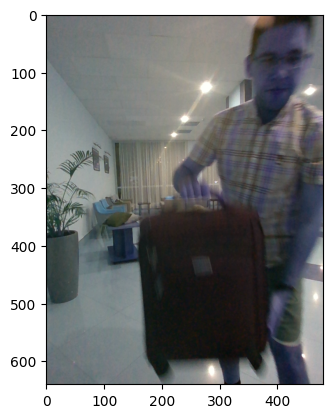

In [6]:
import matplotlib.pyplot as plt
plt.imshow(completed_objects[0]['rgb_image'])